In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.'
train_url = url + 'data'
test_url = url + 'test'

#labels in the dataset
names = ["age","workclass","fnlwgt","education","education-num",
         "marital-status","occupation","relationship","race","sex",
         "capital-gain","capital-loss", "hours-per-week",
         "native-country","income>50k"]

# download data
train_df = pd.read_csv(train_url, names = names, index_col = False, comment = '|')
test_df = pd.read_csv(test_url, names = names, index_col = False, comment = '|')

In [3]:
# Cleaning data and getting rid of symbols and 'None' values
train_df[train_df == '?'] = np.nan
train_df[train_df == ' ?'] = np.nan
train_df.dropna(inplace = True)

test_df[test_df == '?'] = np.nan
test_df[test_df == ' ?'] = np.nan
test_df.dropna(inplace = True)

In [4]:
# 'fnlwgt' is a counter for the number of repeated entries in the census, it has 0 correlation to 
# income so it can be discarded
# education-num is a numerical representation of education with a 1.0 correlation to education 
# so it is discarded as well

train_inputs = pd.get_dummies(train_df.drop(['income>50k', 'education-num', 'fnlwgt'], axis=1))
test_inputs = pd.get_dummies(test_df.drop(['income>50k', 'education-num', 'fnlwgt'], axis=1))

# Ensuring the dimensions are the same for the train and test sets
extra_columns = list(set(train_inputs.columns) - set(test_inputs.columns))
for c in extra_columns:
    test_inputs[c] = 0



# Creating labels from the dataset
train_labels, _ = train_df['income>50k'].factorize()
train_protected, _ = train_df['sex'].factorize() # male = 0, female = 1
test_labels, _ = test_df['income>50k'].factorize()
test_protected, _ = test_df['sex'].factorize() # male = 0, female = 1



# Convert input samples and target labels to tensors
train_inputs = F.normalize(torch.Tensor(train_inputs.values))
train_labels = torch.Tensor(train_labels)
train_protected = torch.Tensor(train_protected)


test_inputs = F.normalize(torch.Tensor(test_inputs.values))
test_labels = torch.Tensor(test_labels)
test_protected = torch.Tensor(test_protected)


# Create a dataset object that pairs the input samples and target labels
train_dataset = TensorDataset(train_inputs, train_labels, train_protected)
test_dataset = TensorDataset(test_inputs, test_labels, test_protected)


# Dataloaders for training and testing
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



In [5]:
# training settings
# input shape for Auto Encoder
input_dim = train_inputs.shape[1]
# layer size for AE
hidden_dim = 100
# Decode down size
encoded_dim = 10
# Check if cuda processing is available
cuda = torch.cuda.is_available()


In [6]:
# All the modules for the algorithm. 
# First is the Autoencoder, a separate encoder and decoder both neural net with 3 hidden layers of 100 neurons.
# A simple logistic regressor to act as the predictor on top of the encoder
# An adversary which acts as a predictor to determine if the protected variable was used or not
# Adversary shares the same architecture as the encoder: a neural net with 3 hidden layers of 100 units 
# with a sigmoid activation function at the end. 

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, encoded_dim)
        
        self.drop = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = torch.relu(x)
        R = self.fc3(x)
        return R

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(encoded_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
        self.drop = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = torch.relu(x)
        Xhat = self.fc3(x)
        return Xhat


class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(encoded_dim, 1)
    
    def forward(self, x):
        Y_hat = torch.sigmoid(self.fc1(x))
        return Y_hat
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(encoded_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self.drop = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = torch.relu(x)
        S_hat = torch.sigmoid(self.fc3(x))
        return S_hat


In [19]:
# parameter for y disc
t = 1

# hyperparamaters for loss function
alpha = 0.05
beta = 50
gamma = 1


# Initializing models

Enc = Encoder()
Dec = Decoder()
Pred = Predictor()
Adv = Discriminator()

# Loss functions
reconstruction_loss = nn.MSELoss()

prediction_loss = nn.BCELoss()

adversary_loss = nn.BCELoss()

# optimizers all using Adam
adv_optimizer = torch.optim.Adam(Adv.parameters(),
                             lr = 0.0001,
                             weight_decay = 1e-8)

pred_optimizer = torch.optim.Adam(Pred.parameters(),
                             lr = 0.0001,
                             weight_decay = 1e-8)

enc_optimizer = torch.optim.Adam(Enc.parameters(),
                             lr = 0.0001,
                             weight_decay = 1e-8)
dec_optimizer = torch.optim.Adam(Dec.parameters(),
                             lr = 0.0001,
                             weight_decay = 1e-8)

In [20]:
epochs = 100

losses = []

for epoch in range(epochs):
    U = 1
    for X, Y, S in dataloader:
       
        # decoding
        R = Enc(X)
        X_hat = Dec(R)
        Y_hat = Pred(R)
        S_hat = Adv(R)
        
        # loss for the reconstruction
        C = reconstruction_loss(X_hat, X)
        
        # loss for the predictor
        E = prediction_loss(Y_hat, Y.unsqueeze(1))
        
        # loss for adversary
        D = adversary_loss(S_hat, S.unsqueeze(1))
        
        # joint loss 
        L = alpha*C + beta*D + gamma*E
        

        
        # Gradient steps
        L.backward()
        enc_optimizer.step()
        dec_optimizer.step()
    
        if U:
            # Updating Predictor
            pred_optimizer.step()
            pred_optimizer.zero_grad()

        else:
            # Updating Adversary
            adv_optimizer.step()
            adv_optimizer.zero_grad()
            

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
            
        #alternative gradient step 
        U = not U
        
        # Storing the losses in a list for plotting     
        if epoch%10 == 0:
            losses.append(L.mean().cpu().detach().numpy())
    if (epoch+1)%10 == 0:
        print(epoch+1)

10
20
30
40
50
60
70
80
90
100


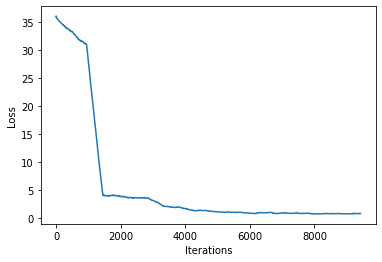

In [21]:
# Plotting the rolling average for losses 
avg_loss = [np.mean(losses[n-500:n]) if n > 500 else np.mean(losses[:n]) 
           for n in range(1, len(losses))] 

# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(avg_loss)

In [22]:
# Set the model to evaluation mode
Enc.eval()
Pred.eval()

pred_female = 0
true_female = 0 
correct = 0
total = 0
 
# Iterate over the test set
with torch.no_grad():
    for inputs, labels, protected  in test_loader:
        encoding = Enc(inputs)
        predictions = Pred(encoding).squeeze(1) > 0.5
        labels = labels > 0.5
        total += labels.size(0)
        results = (predictions == labels)
        correct += results.sum()
        
        # Check y_disc
        pred_female += predictions.sum()
        true_female += labels.sum()
    
pred_male = total - pred_female
true_male = total - true_female      


In [23]:
y_disc = abs(pred_male/true_male - pred_female/true_female)
y_acc = correct / total
y_t_delta = y_acc - t*y_disc

print(f"Accuracy: {y_acc}\nY_disc: {y_disc}\nY_delta: {y_t_delta}")


Accuracy: 0.8150730133056641
Y_disc: 0.02543926239013672
Y_delta: 0.7896337509155273
